In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

sns.set_style('white')
results_path = Path('results', 'decision_trees')

np.random.seed(42)

if not results_path.exists():
    results_path.mkdir(parents=True)

In [2]:
class MultipleTimeSeriesCV:
    def __init__(self, n_splits=3, train_period_length=126, test_period_length=21, lookahead=None, date_idx='date', shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start]) & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start]) & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
with pd.HDFStore('data/data.h5') as store:
    data = store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

In [5]:
data.tail()

atr   bb_down   bb_high    bb_low    bb_mid     bb_up  \
ticker date                                                                     
ZION   2017-07-31 -0.181012  0.038654  3.841345  3.794321  3.817833  0.008370   
       2017-08-31 -0.274439  0.013926  3.849378  3.785152  3.817265  0.050299   
       2017-09-30 -0.155049  0.139050  3.884183  3.735894  3.810038  0.009239   
       2017-10-31 -0.134904  0.016495  3.889834  3.843392  3.866613  0.029946   
       2017-11-30  0.125608  0.120711  3.918737  3.802252  3.860494 -0.004226   

                       macd      natr        rsi   sector  ...       RMW  \
ticker date                                                ...             
ZION   2017-07-31  0.657033  1.885520  62.089693  Finance  ... -0.952888   
       2017-08-31 -0.259812  1.804202  43.528169  Finance  ... -0.956016   
       2017-09-30  0.876060  1.844395  70.270187  Finance  ... -0.981499   
       2017-10-31  0.270798  1.902929  51.467907  Finance  ... -0.948183   
       2017-11-30  0.698692  2.147435  69.398587  Finance  ... -1.022824   

                        CMA  momentum_3  momentum_6  momentum_3_6  \
ticker date                                                         
ZION   2017-07-31 -1.804549    0.010813   -0.019481     -0.030294   
       2017-08-31 -1.796359    0.063992    0.030177     -0.033815   
       2017-09-30 -1.779831   -0.055484   -0.060265     -0.004781   
       2017-10-31 -1.839045    0.024469    0.041188      0.016719   
       2017-11-30 -1.445504   -0.023423   -0.030024     -0.006601   

                   momentum_12  momentum_3_12  year  month    target  
ticker date                                                           
ZION   2017-07-31     0.009953      -0.000859  2017      7 -0.034067  
       2017-08-31     0.064885       0.000892  2017      8  0.080623  
       2017-09-30    -0.044329       0.011155  2017      9 -0.015261  
       2017-10-31     0.046986       0.022517  2017     10  0.066509  
       2017-11-30    -0.047517      -0.024094  2017     11  0.025832  

[5 rows x 27 columns]

In [15]:
# Generate two lags of monthly returns
X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby(level='ticker').return_1m.shift()
X2 = X2.dropna()
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77176 entries, ('A', Timestamp('2007-01-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       77176 non-null  float64
 1   t-1     77176 non-null  float64
 2   t-2     77176 non-null  float64
dtypes: float64(3)
memory usage: 2.1+ MB


<Axes: xlabel='y', ylabel='Density'>

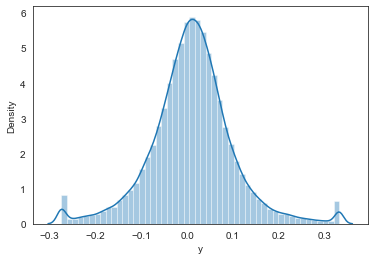

In [16]:
# some fat-tail data
y2 = X2.y
X2 = X2.drop('y', axis=1)

sns.distplot(y2)

In [17]:
# Configure Tree
reg_tree_t2 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=6, min_samples_split=2,
                                    min_samples_leaf=50, min_weight_fraction_leaf=0.0, max_features=None,
                                    random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0)

In [18]:
%%timeit
reg_tree_t2.fit(X=X2, y=y2)

84.6 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


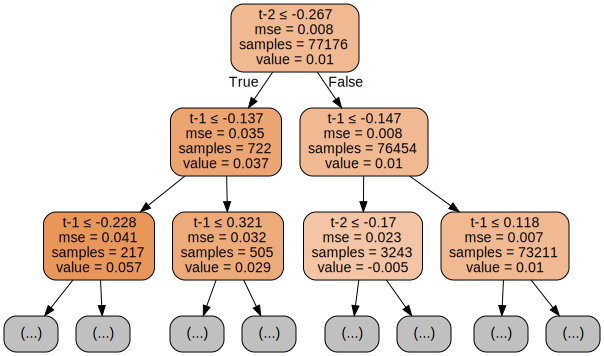

In [21]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2, out_file=out_file.as_posix(), feature_names=X2.columns,
                          max_depth=2, filled=True, rounded=True, special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [26]:
# statsmodels OLS
ols_model = sm.OLS(endog=y2, exog=sm.add_constant(X2))

In [27]:
%%timeit
ols_model.fit()

64.7 µs ± 6.68 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
result = ols_model.fit()
print(result.summary())
# Omnibus: D'Angostino's Test - following normalized distribution as the value is higher
# Prob(Omnibus): significant decision when, generally, below 0.05 is good)
# Skew indicates symmetric if the value closes to 0
# Kurtosis indicates normalized distribution if the value closes 3
# Jarque-Bera - bigger value indicates normal distribution
# Cond. No. - the possibility of multicollinearity exists when the value is higher than 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.83
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.53e-14
Time:                        09:51:27   Log-Likelihood:                 75823.
No. Observations:               77176   AIC:                        -1.516e+05
Df Residuals:                   77173   BIC:                        -1.516e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.000     30.232      0.0

In [29]:
# sklearn Linear Regression
lin_reg = LinearRegression()

In [30]:
%%timeit
lin_reg.fit(X=X2,y=y2)
# decision tree is much faster than LinearRegression

2.77 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print(lin_reg.intercept_, lin_reg.coef_)

0.009971254720772654 [ 0.02269243 -0.01794206]


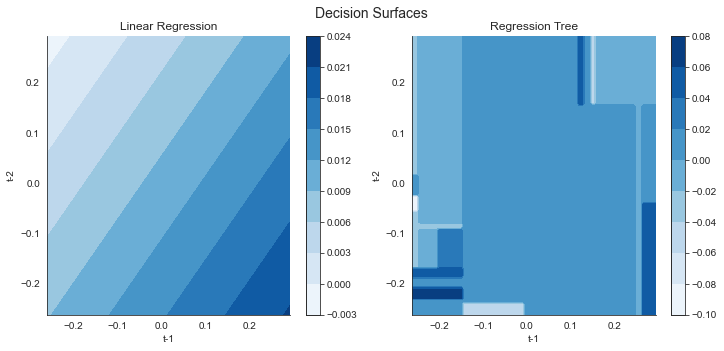

In [41]:
# Linear Regression vs Regression Tree Decision Surfaces
# np.meshgrid(): create rectangle grid & return transposed grid
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
# ravel(): flattening effect, reshape to 1 dimension matrix, option: order='C, F, K
# if the original value changes, ravel() and reshape() will change. but not for flatten()
X_data = np.c_[t1.ravel(), t2.ravel()]
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.subplots_adjust(top=.9);

In [42]:
X_data[:10]

array([[-0.26113826, -0.26286302],
       [-0.25553671, -0.26286302],
       [-0.24993517, -0.26286302],
       [-0.24433362, -0.26286302],
       [-0.23873207, -0.26286302],
       [-0.23313053, -0.26286302],
       [-0.22752898, -0.26286302],
       [-0.22192743, -0.26286302],
       [-0.21632588, -0.26286302],
       [-0.21072434, -0.26286302]])

In [43]:
# Simple Classification Tree with Time Series Data
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

def gini(f):
    return 2*f*(1-f)

def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

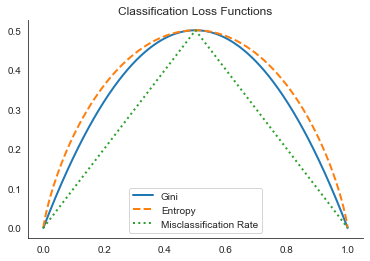

In [45]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, style=['-', '--', ':']))
sns.despine()
# penalty: Entropy > Gini > Misclassification Rate
# time for calculation: Entropy > Misclassification Rate > Gini(best performance!)

In [46]:
%%timeit
misclassification_rate(x)

19.5 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [47]:
%%timeit
gini(x)

15.1 µs ± 1 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [48]:
%%timeit
entropy(x)

215 µs ± 6.03 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=1000,
                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
                                     random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     class_weight=None)

In [51]:
y_binary = (y2>0).astype(int)
y_binary.value_counts()

1    43399
0    33777
Name: y, dtype: int64

In [52]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

103 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


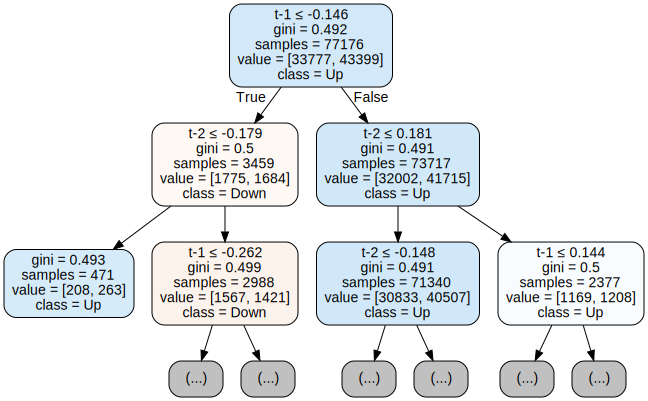

In [54]:
# Visualize Tree
out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2, out_file=out_file.as_posix(), feature_names=X2.columns,
                           class_names=['Down', 'Up'], max_depth=2, filled=True, rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [55]:
# Statsmodels
log_reg_sm = sm.Logit(endog=y_binary, exog=sm.add_constant(X2))

In [56]:
%%timeit
log_reg_sm.fit(disp=False)

17.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
log_result = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.685278
         Iterations 4


In [58]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                77176
Model:                          Logit   Df Residuals:                    77173
Method:                           MLE   Df Model:                            2
Date:                Sat, 06 May 2023   Pseudo R-squ.:               0.0001127
Time:                        10:48:08   Log-Likelihood:                -52887.
converged:                       True   LL-Null:                       -52893.
Covariance Type:            nonrobust   LLR p-value:                  0.002584
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2485      0.007     33.873      0.000       0.234       0.263
t-1            0.2712      0.080      3.394      0.001       0.115       0.428
t-2           -0.0560      0.080     -0.701      0.4

In [59]:
# sklearn
log_reg_sk = LogisticRegression()

In [60]:
%%timeit
log_reg_sk.fit(X=X2, y=y_binary)

75 ms ± 47.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
log_reg_sk.fit(X=X2, y=y_binary)
log_reg_sk.coef_

array([[ 0.26951533, -0.05558622]])

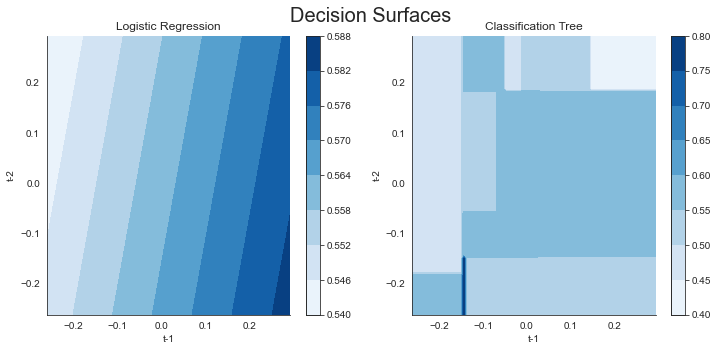

In [63]:
# Decision Surfaces: Classifier Tree vs. Logistic Regression
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = log_reg_sk.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
sns.despine()
fig.subplots_adjust(top=.9);

In [80]:
# Train-Test Split
X = pd.get_dummies(data.drop('target', axis=1))
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
regression_tree = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=5, min_samples_split=2,
                                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
                                        random_state=42, max_leaf_nodes=None, min_impurity_decrease=0.0)

In [82]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, random_state=42)

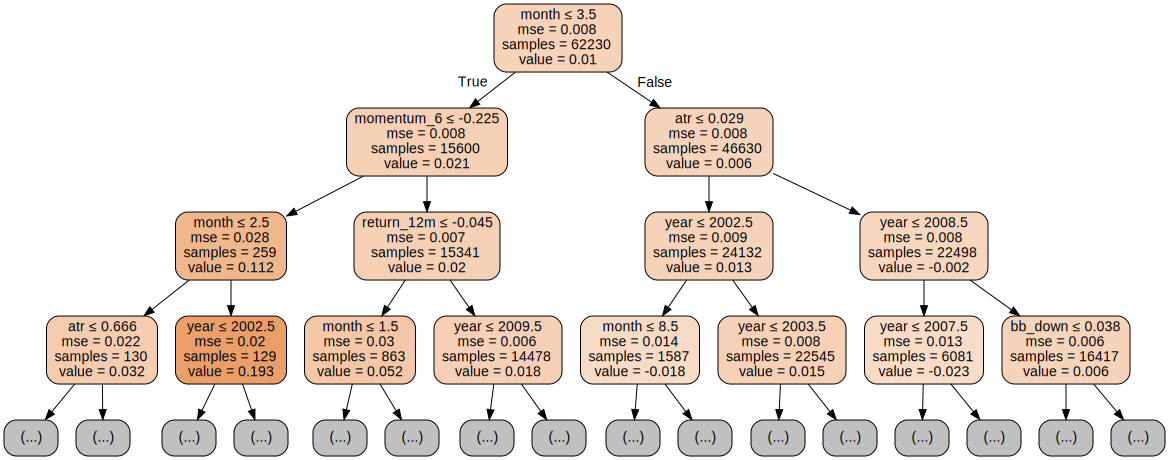

In [83]:
out_file = results_path / 'reg_tree.dot'
dot_data = export_graphviz(regression_tree, out_file=out_file.as_posix(), feature_names=X_train.columns,
                           max_depth=3, filled=True, rounded=True, special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [84]:
# Evaluate Test Set
y_pred = regression_tree.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.08659823080682824

In [85]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

18.95 (p-value=0.00%)


In [86]:
# Train-Test Split
y_binary = (y>0).astype(int)
y_binary.value_counts()

1    43733
0    34055
Name: target, dtype: int64

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

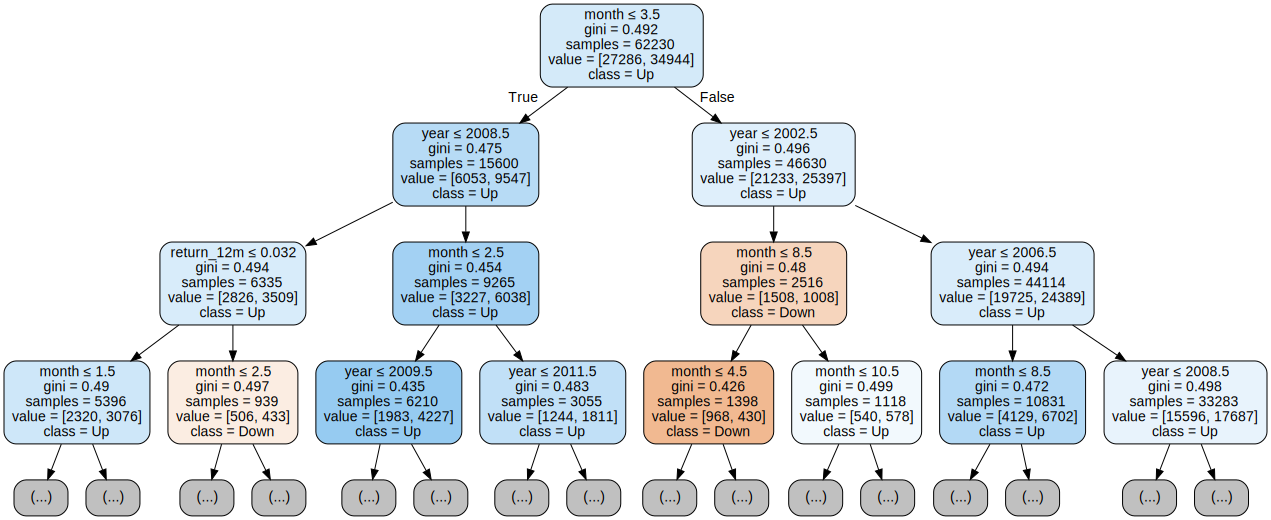

In [88]:
# Plot Tree
out_file = results_path / 'clf_tree.dot'
dot_data = export_graphviz(clf, out_file=out_file.as_posix(), feature_names=X.columns,
                           class_names=['Down', 'Up'], max_depth=3, filled=True, rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [89]:
y_score = clf.predict_proba(X=X_test)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_test)

0.6162765470832821

In [67]:
# from sklearn.tree._tree import Tree
# help(Tree)

In [91]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

tree_to_code(clf_tree_t2, X2.columns)

def tree(t-1, t-2):
   if t-1 <= -14.64%
     if t-2 <= -17.93%
       return 55.84%
     else:  # if t-2 > -17.93%
       if t-1 <= -26.16%
         return 41.08%
       else:  # if t-1 > -26.16%
         if t-1 <= -26.14%
           return 100.00%
         else:  # if t-1 > -26.14%
           if t-1 <= -14.66%
             return 49.09%
           else:  # if t-1 > -14.66%
             return 0.00%
   else:  # if t-1 > -14.64%
     if t-2 <= 18.14%
       if t-2 <= -14.83%
         if t-2 <= -14.85%
           if t-1 <= -14.31%
             return 77.78%
           else:  # if t-1 > -14.31%
             return 52.24%
         else:  # if t-2 > -14.85%
           return 0.00%
       else:  # if t-2 > -14.83%
         if t-1 <= -6.59%
           if t-2 <= -6.04%
             return 58.58%
           else:  # if t-2 > -6.04%
             return 53.78%
         else:  # if t-1 > -6.59%
           if t-1 <= 2.68%
             return 58.02%
           else:  # if t-1 > 2.68%
             r

In [92]:
# Cross-validation parameters
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits, train_period_length=train_period_length,
                          test_period_length=test_period_length, lookahead=lookahead)
max_depths = range(1, 16)

In [93]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15], 'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}

In [94]:
clf = DecisionTreeClassifier(random_state=42)
gridsearch_clf = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', n_jobs=-1,
                          cv=cv, refit=True, return_train_score=True)
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x000002401E610280>,
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [97]:
print(gridsearch_clf.best_params_, gridsearch_clf.best_score_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 100} 0.5276899484168457


In [98]:
# Define Custom IC score
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]
ic = make_scorer(rank_correl)

reg_tree = DecisionTreeRegressor(random_state=42)
# refit=True : automatically fit() by best_params_
gridsearch_reg = GridSearchCV(estimator=reg_tree, param_grid=param_grid, scoring=ic, n_jobs=-1, cv=cv,
                              refit=True, return_train_score=True)
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x000002401E610280>,
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring=make_scorer(rank_correl))

In [105]:
print(gridsearch_reg.best_score_, gridsearch_clf.best_score_)

0.052152646155679626 0.5276899484168457


In [106]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,8,15
max_features,sqrt,sqrt
min_samples_leaf,5,100


In [107]:
# Classifier Cross-Validation
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves


train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_leaf=5,
                                 max_features='sqrt', random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(clf))

clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [112]:
clf_leaves.tail() # node and leaf count

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
5,2,4,8,16,28,52,82,125,225,372,462,619,986,1299,1597
6,2,4,8,16,32,59,112,191,337,472,649,953,1114,1464,1871
7,2,4,8,16,29,50,83,136,207,317,489,595,1037,1345,1450
8,2,4,8,16,31,62,102,165,302,414,486,816,1061,1074,1690
9,2,4,8,16,30,53,102,191,288,431,703,923,1157,1285,1658


In [113]:
clf_cv_data = pd.concat([pd.melt(clf_train_scores, var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Train'),
                         pd.melt(clf_valid_scores, var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Valid')])

In [114]:
# Regression tree cross-validation
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=50, max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = spearmanr(train_pred, y_train)[0]
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = spearmanr(test_pred, y_test)[0]
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [118]:
reg_cv_data = (pd.melt(reg_train_scores, var_name='Max. Depth', value_name='IC').assign(Data='Train').append(
    pd.melt(reg_valid_scores, var_name='Max. Depth', value_name='IC').assign(Data='Valid')))

In [119]:
reg_cv_data.tail()

,Max. Depth,IC,Data
145,15,0.042145,Valid
146,15,-0.068175,Valid
147,15,-0.032448,Valid
148,15,0.057003,Valid
149,15,0.039241,Valid


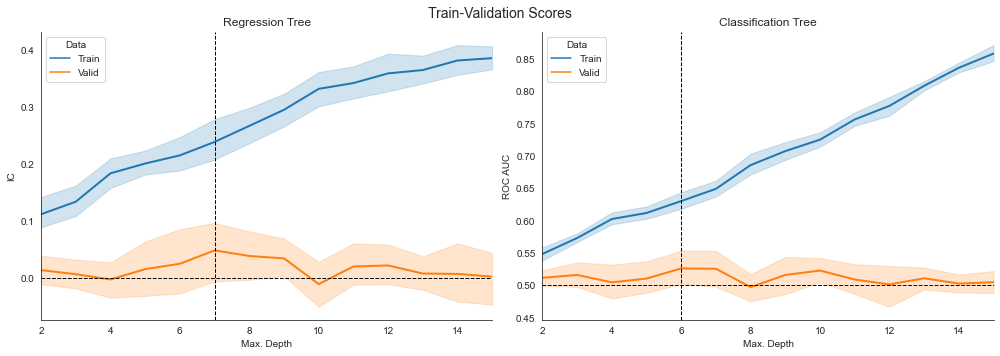

In [120]:
# Compare CV Results
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.lineplot(data=reg_cv_data, x='Max. Depth', y='IC', hue='Data', ci=95, ax=axes[0], lw=2)

axes[0].set_title('Regression Tree')
axes[0].axvline(x=reg_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[0].axhline(y=0, ls='--', c='k', lw=1)

sns.lineplot(data=clf_cv_data, x='Max. Depth', y='ROC AUC', hue='Data', ci=95, ax=axes[1], lw=2)

axes[1].set_title('Classification Tree')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=.5, ls='--', c='k', lw=1)
for ax in axes:
    ax.set_xlim(min(param_grid['max_depth']), max(param_grid['max_depth']))

fig.suptitle(f'Train-Validation Scores', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.91)

In [122]:
# Classifier
sizes = np.arange(.1, 1.01, .1)
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_, X, y_binary,
                                                         train_sizes=sizes, cv=cv, scoring='roc_auc',
                                                         n_jobs=-1, shuffle=True, random_state=42)
clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes), var_name='Train Size',
            value_name='ROC AUC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes), var_name='Train Size',
            value_name='ROC AUC').assign(Data='Valid')])
clf_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   ROC AUC     200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


In [124]:
clf_lc_data.tail()

,Train Size,ROC AUC,Data
95,26906,0.555474,Valid
96,26906,0.508461,Valid
97,26906,0.517867,Valid
98,26906,0.526740,Valid
99,26906,0.558015,Valid


In [125]:
# Regression Tree
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_, X, y,
                                                         train_sizes=sizes, cv=cv, scoring=ic,
                                                         n_jobs=-1, shuffle=True, random_state=42)
reg_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes), var_name='Train Size',
            value_name='IC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes), var_name='Train Size',
            value_name='IC').assign(Data='Valid')])
reg_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   IC          200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


In [127]:
reg_lc_data.tail()

,Train Size,IC,Data
95,26906,0.218432,Valid
96,26906,-0.119277,Valid
97,26906,0.069881,Valid
98,26906,0.082617,Valid
99,26906,0.070046,Valid


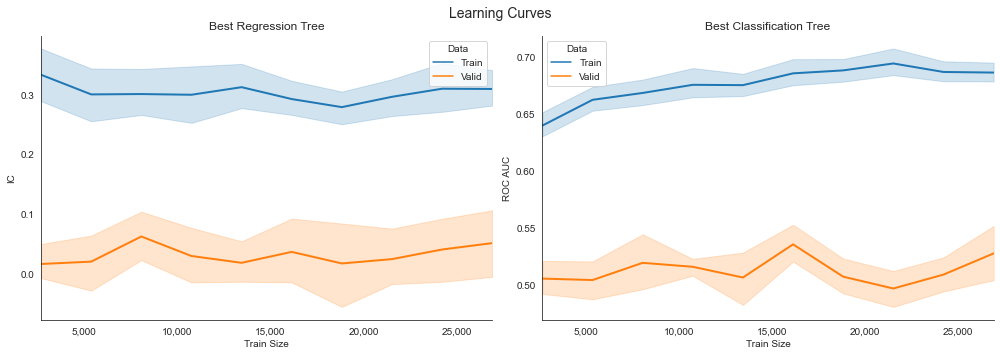

In [128]:
# Compare Learning Curves
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
xmin, xmax = reg_lc_data['Train Size'].min(), reg_lc_data['Train Size'].max()

sns.lineplot(data=reg_lc_data, x='Train Size', y='IC', hue='Data', ci=95,  ax=axes[0], lw=2)
axes[0].set_title('Best Regression Tree')
axes[0].set_ylabel('IC')

axes[0].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.lineplot(data=clf_lc_data, x='Train Size', y='ROC AUC', hue='Data', ci=95, ax=axes[1], lw=2)
axes[1].set_title('Best Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

for i in [0, 1]:
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].tick_params(axis='both', which='minor', labelsize=8)
    axes[i].set_xlim(xmin, xmax)

fig.suptitle('Learning Curves', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

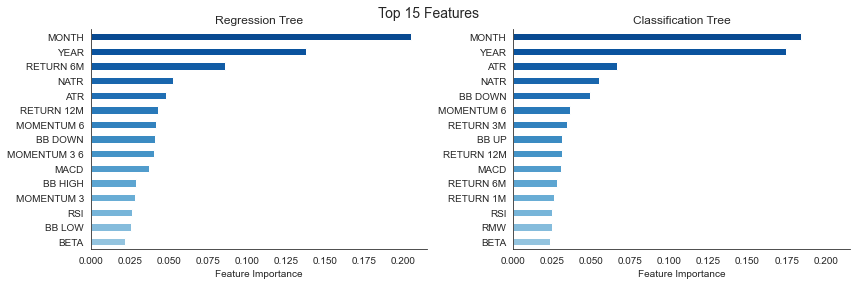

In [129]:
# Feature Importance
top_n = 15
labels = X.columns.str.replace('_', ' ').str.upper()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_,
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_,
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fig, axes= plt.subplots(ncols=2, figsize=(12,4), sharex=True)
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Claessification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[0], title='Regression Tree', color=color)
axes[0].set_xlabel('Feature Importance')
axes[1].set_xlabel('Feature Importance')
fig.suptitle(f'Top {top_n} Features', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);